In [1]:
import pandas as pd
import seaborn as sns
import sys
import shap
import uuid
sys.path.append('/Users/alexander_wong/Documents/playlist-success/')
from datetime import datetime
import pickle
from src.constants import *
from src.data_transformations import create_features, classify_success
from src.model import create_holdout, ShapObject
import uuid
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_columns = 200
sns.set_style('darkgrid')

%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
raw_data = pd.read_parquet("../data/streamlit_data.parquet")

# SHAP Model Training

## Genre

In [3]:
# Model parameters
holdout_fraction = 0.10
users_threshold = 10
success_threshold = 0.75

In [4]:
dict_models = {}
dict_explainers = {}
dict_shap = {}
dict_train = {}
dict_exp = {}
failed = []

In [5]:
BASE_FEATURES = [
    'n_tracks',
    'n_artists',
    'n_albums',
    'tracks_per_album',
    'artists_per_album',
    'title_length'
]
ACOUSTIC_FEATURES = [
    'popularity_mean',
    'acousticness_mean',
    'danceability_mean',
    'duration_mean',
    'energy_mean',
    'instrumentalness_mean',
    'liveness_mean',
    'loudness_mean',
    'speechiness_mean',
    'valence_mean', 
    'popularity_std',
    'acousticness_std',
    'danceability_std',
    'duration_std',
    'energy_std',
    'instrumentalness_std',
    'liveness_std',
    'loudness_std',
    'speechiness_std',
    'valence_std'
]

In [6]:
MMS = MinMaxScaler(feature_range=(0, 100))

In [7]:
data = pd.merge(
     raw_data[["playlist_uri", "users_adjusted", "streaming_ratio_users"] + BASE_FEATURES + MODEL_CATEGORICAL_FEATURES],
     pd.DataFrame(MMS.fit_transform(raw_data[ACOUSTIC_FEATURES]), columns=ACOUSTIC_FEATURES),
     left_index=True,
     right_index=True
 )          

In [8]:
data.columns

Index(['playlist_uri', 'users_adjusted', 'streaming_ratio_users', 'n_tracks',
       'n_artists', 'n_albums', 'tracks_per_album', 'artists_per_album',
       'title_length', 'genre_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2',
       'mood_3', 'popularity_mean', 'acousticness_mean', 'danceability_mean',
       'duration_mean', 'energy_mean', 'instrumentalness_mean',
       'liveness_mean', 'loudness_mean', 'speechiness_mean', 'valence_mean',
       'popularity_std', 'acousticness_std', 'danceability_std',
       'duration_std', 'energy_std', 'instrumentalness_std', 'liveness_std',
       'loudness_std', 'speechiness_std', 'valence_std'],
      dtype='object')

In [ ]:
for genre in GENRES:
    try:
        from pycaret.classification import *
        logging.info(f'{genre}-----------------------------------------------------------------------------------------')
        fig, ax = plt.subplots()
        plt.title(f"{genre}", size=40)
        plt.show()

        genre_frame = data.loc[lambda f: f["genre_1"].isin([genre])]
        labelled_frame = classify_success(genre_frame, users_threshold, success_threshold)
        train_frame, holdout_frame = create_holdout(labelled_frame, holdout_fraction=holdout_fraction, default_columns=False)

        print(f"Train size: {len(train_frame)}")
        print(f"Train size: {len(holdout_frame)}")

        experiment = setup(
            data=train_frame,
            numeric_features=BASE_FEATURES + ACOUSTIC_FEATURES,
            categorical_features=MODEL_CATEGORICAL_FEATURES,
            target="success_streaming_ratio_users",
            ignore_features=["playlist_uri", "users_adjusted", "streaming_ratio_users"],
            test_data=holdout_frame,
            session_id=123,
            ignore_low_variance=True,
            remove_outliers=True,
            fix_imbalance=True,
            remove_multicollinearity=True,
            log_experiment=True,
            log_data=True,
            fold=10,
            n_jobs=-1,
            combine_rare_levels=True,
            experiment_name=f'{genre}_2',
            feature_interaction=True,
            feature_ratio=True,
            polynomial_features=True,
            silent=True,
    )
        model = create_model(
            'xgboost',
            n_estimators=1000,
            learning_rate =0.2,
            max_depth=8,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs = 16,
            scale_pos_weight=1
        )
        exp = pull()
        dict_exp[genre] = exp

        # Track & Save the model
        dict_models[genre] = model
        model_name = f'{genre}_xgboost_2020-04-14.pickle.dat'
        pickle.dump(model, open(model_name, "wb"))
        logging.info("Model Save Success!")

        X_train = get_config(variable="X_train")
        y_train = get_config(variable="y_train")

        X_test = get_config(variable="X_test")
        y_test = get_config(variable="y_test")

        view = pd.merge(y_train, X_train, left_index=True, right_index=True).reset_index(drop=True)
        dict_train[genre] = view

        X_train.to_parquet(f"../data/pycaret/X_train_{genre}_2")
        pd.DataFrame(y_train).to_parquet(f"../data/pycaret/y_train_{genre}_2")
        X_test.to_parquet(f"../data/pycaret/X_test_{genre}_2")
        pd.DataFrame(y_test).to_parquet(f"../data/pycaret/y_test_{genre}_2")

        # PLOTS
        explainer = shap.TreeExplainer(model)
        dict_explainers[genre]=explainer

        shap_values = explainer.shap_values(X_train.to_numpy())
        dict_shap[genre]=shap_values

        display(genre)
        display(shap.summary_plot(shap_values, X_train, plot_type="bar"))
        display(shap.summary_plot(shap_values, X_train))
    except:
        failed.append(genre)
        pass

INFO:logs:Logging experiment in MLFlow
  File "/Users/alexander_wong/Documents/playlist-success/venv-playlist-success/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 1699, in setup
    mlflow.create_experiment(exp_name_log)
  File "/Users/alexander_wong/Documents/playlist-success/venv-playlist-success/lib/python3.8/site-packages/mlflow/tracking/fluent.py", line 831, in create_experiment
    return MlflowClient().create_experiment(name, artifact_location)
  File "/Users/alexander_wong/Documents/playlist-success/venv-playlist-success/lib/python3.8/site-packages/mlflow/tracking/client.py", line 456, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location)
  File "/Users/alexander_wong/Documents/playlist-success/venv-playlist-success/lib/python3.8/site-packages/mlflow/tracking/_tracking_service/client.py", line 140, in create_experiment
    return self.store.create_experiment(name=name, artifact_location=artifact_location,)
  File "/Us

INFO:logs:setup() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=xgboost, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={'n_estimators': 1000, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': 16, 'scale_pos_weight': 1})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=4)

Initiated  . . . . . . . . . . . . . . . . . .                   16:20:19
Status     . . . . . . . . . . . . . . . . . .           Finalizing Model
Estimator  . . . . . . . . . . . . . . . . . .  Extreme Gradient Boosting

Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []

INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Extreme Gradient Boosting Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model


## ALL

In [ ]:
genre = "ALL"

genre_frame = data
labelled_frame = classify_success(genre_frame, users_threshold, success_threshold)
train_frame, holdout_frame = create_holdout(labelled_frame, holdout_fraction=holdout_fraction)

print(f"Train size: {len(train_frame)}")
print(f"Train size: {len(holdout_frame)}")

from pycaret.classification import *
logging.info(f'{genre}-----------------------------------------------------------------------------------------')
fig, ax = plt.subplots()
plt.title(f"{genre}", size=40)
plt.show()

genre_frame = data.loc[lambda f: f["genre_1"].isin([genre])]
labelled_frame = classify_success(genre_frame, users_threshold, success_threshold)
train_frame, holdout_frame = create_holdout(labelled_frame, holdout_fraction=holdout_fraction, default_columns=False)

print(f"Train size: {len(train_frame)}")
print(f"Train size: {len(holdout_frame)}")

experiment = setup(
    data=train_frame,
    numeric_features=BASE_FEATURES + ACOUSTIC_FEATURES,
    categorical_features=MODEL_CATEGORICAL_FEATURES,
    target="success_streaming_ratio_users",
    ignore_features=["playlist_uri", "users_adjusted", "streaming_ratio_users"],
    test_data=holdout_frame,
    session_id=123,
    ignore_low_variance=True,
    remove_outliers=True,
    fix_imbalance=True,
    remove_multicollinearity=True,
    log_experiment=True,
    log_data=True,
    fold=10,
    n_jobs=-1,
    combine_rare_levels=True,
    experiment_name=f'{genre}_2',
    feature_interaction=True,
    feature_ratio=True,
    polynomial_features=True,
    silent=True,
)
model = create_model(
    'xgboost',
    n_estimators=1000,
    learning_rate =0.2,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs = 16,
    scale_pos_weight=1
)
exp = pull()
dict_exp[genre] = exp

# Track & Save the model
dict_models[genre] = model
model_name = f'{genre}_xgboost_2020-04-14.pickle.dat'
pickle.dump(model, open(model_name, "wb"))
logging.info("Model Save Success!")

X_train = get_config(variable="X_train")
y_train = get_config(variable="y_train")

X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")

view = pd.merge(y_train, X_train, left_index=True, right_index=True).reset_index(drop=True)
dict_train[genre] = view

X_train.to_parquet(f"../data/pycaret/X_train_{genre}_2")
pd.DataFrame(y_train).to_parquet(f"../data/pycaret/y_train_{genre}_2")
X_test.to_parquet(f"../data/pycaret/X_test_{genre}_2")
pd.DataFrame(y_test).to_parquet(f"../data/pycaret/y_test_{genre}_2")

# PLOTS
explainer = shap.TreeExplainer(model)
dict_explainers[genre]=explainer

shap_values = explainer.shap_values(X_train.to_numpy())
dict_shap[genre]=shap_values

display(genre)
display(shap.summary_plot(shap_values, X_train, plot_type="bar"))
display(shap.summary_plot(shap_values, X_train))

# SHAP BY GENRE

In [9]:
dict_explainers.keys()

dict_keys(['Alternative', 'Blues', "Children's", 'Classical', 'Country & Folk', 'Dance & House', 'Easy Listening', 'Electronica', 'Indie Rock', 'Jazz', 'Latin', 'Metal', 'New Age', 'Other', 'Pop', 'Punk', 'R&B', 'Rap', 'Reggae', 'Religious', 'Rock', 'Soundtrack', 'Spoken & Audio', 'Traditional', '-', 'ALL'])

In [10]:
dict_train.keys()

dict_keys(['Alternative', 'Blues', "Children's", 'Classical', 'Country & Folk', 'Dance & House', 'Easy Listening', 'Electronica', 'Indie Rock', 'Jazz', 'Latin', 'Metal', 'New Age', 'Other', 'Pop', 'Punk', 'R&B', 'Rap', 'Reggae', 'Religious', 'Rock', 'Soundtrack', 'Spoken & Audio', 'Traditional', '-', 'ALL'])

In [11]:
dict_shap.keys()

dict_keys(['Alternative', 'Blues', "Children's", 'Classical', 'Country & Folk', 'Dance & House', 'Easy Listening', 'Electronica', 'Indie Rock', 'Jazz', 'Latin', 'Metal', 'New Age', 'Other', 'Pop', 'Punk', 'R&B', 'Rap', 'Reggae', 'Religious', 'Rock', 'Soundtrack', 'Spoken & Audio', 'Traditional', '-', 'ALL'])

## Alternative

'Alternative'

3326

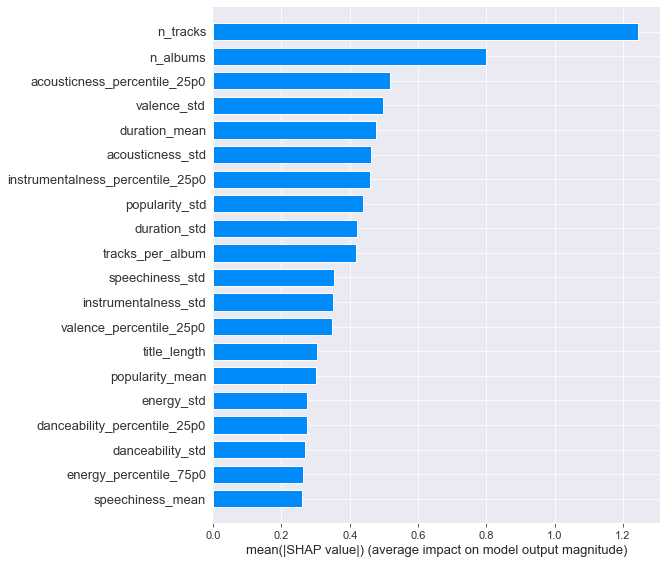

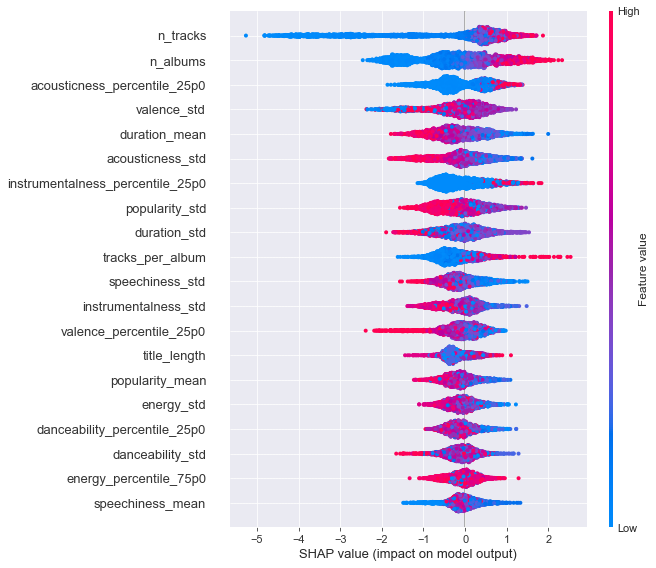

In [23]:
genre = "Alternative"

display(genre)
display(len(dict_train[genre]))
shap.summary_plot(dict_shap[genre], dict_train[genre].drop(columns="success_streaming_ratio_users"), plot_type="bar")
shap.summary_plot(dict_shap[genre], dict_train[genre].drop(columns="success_streaming_ratio_users"))

In [24]:
def shap_helper(genre, dict_shap, dict_train):
    display(genre)
    display(len(dict_train[genre]))
    shap.summary_plot(dict_shap[genre], dict_train[genre].drop(columns="success_streaming_ratio_users"), plot_type="bar")
    shap.summary_plot(dict_shap[genre], dict_train[genre].drop(columns="success_streaming_ratio_users"))

## Blues

'Blues'

87

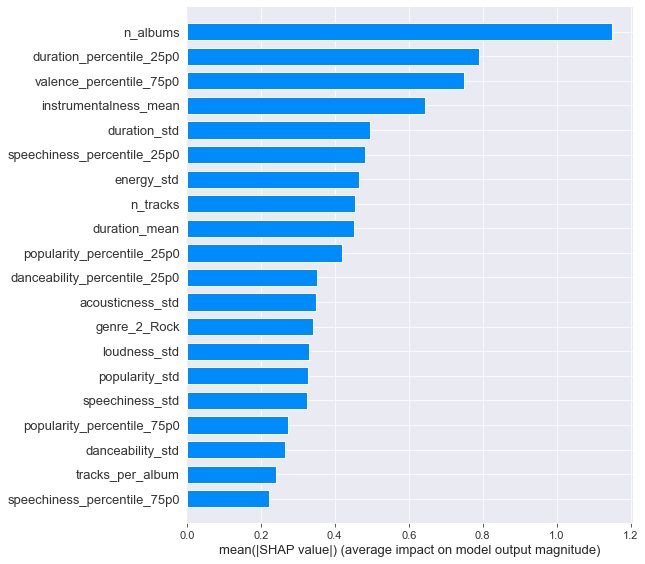

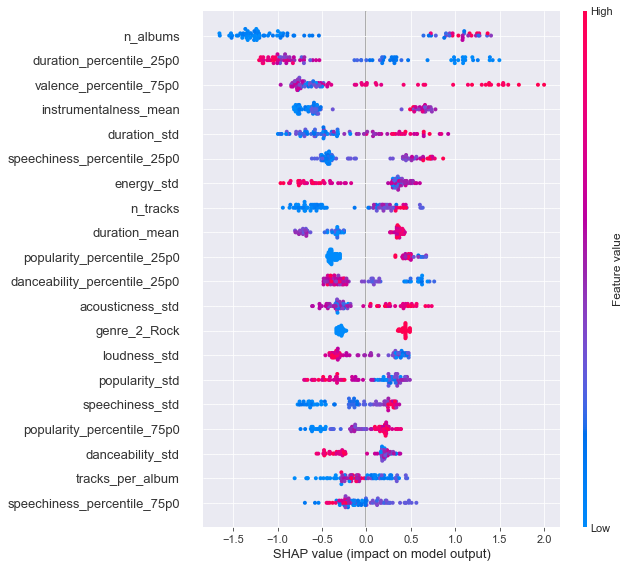

In [28]:
genre = "Blues"
shap_helper(genre, dict_shap, dict_train)

## Children's

"Children's"

536

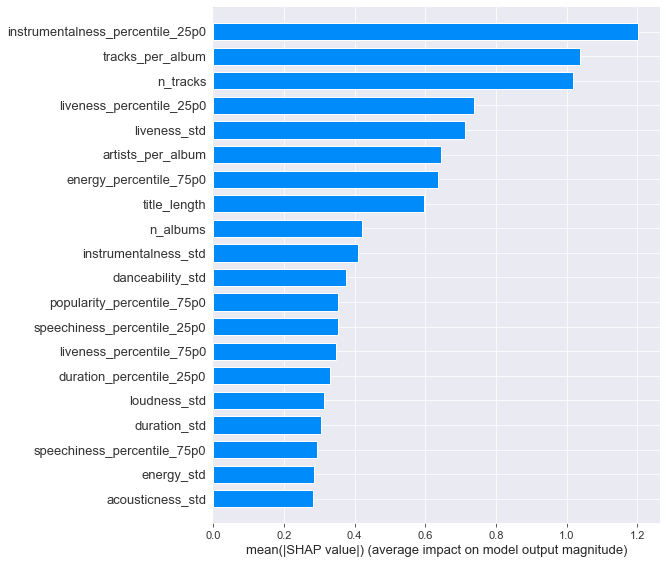

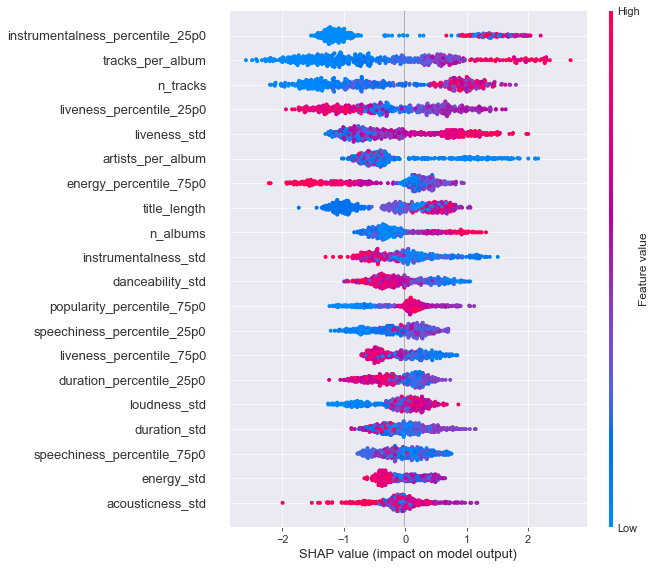

In [29]:
shap_helper("Children's", dict_shap, dict_train)

## Classical

'Classical'

821

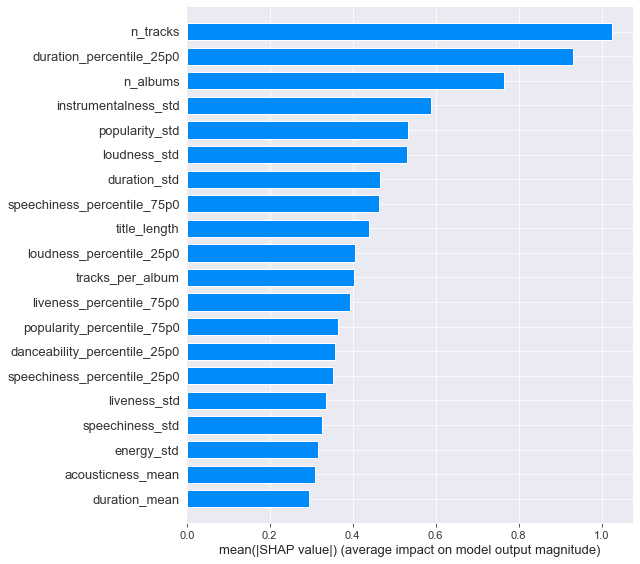

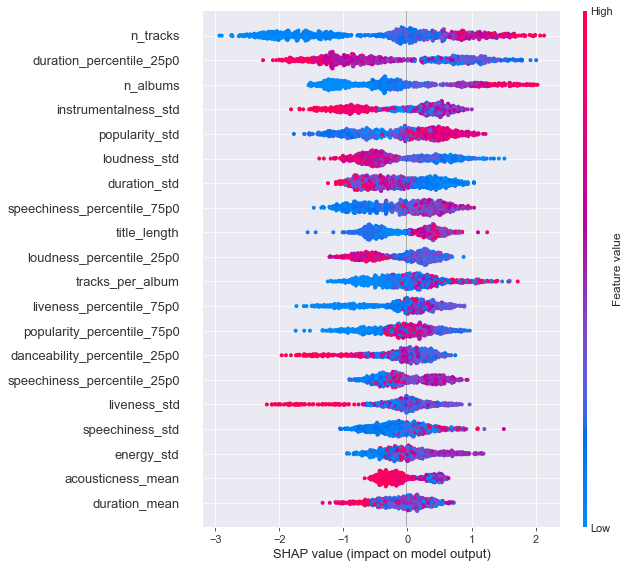

In [31]:
shap_helper("Classical", dict_shap, dict_train)

## Country & Folk

'Country & Folk'

2956

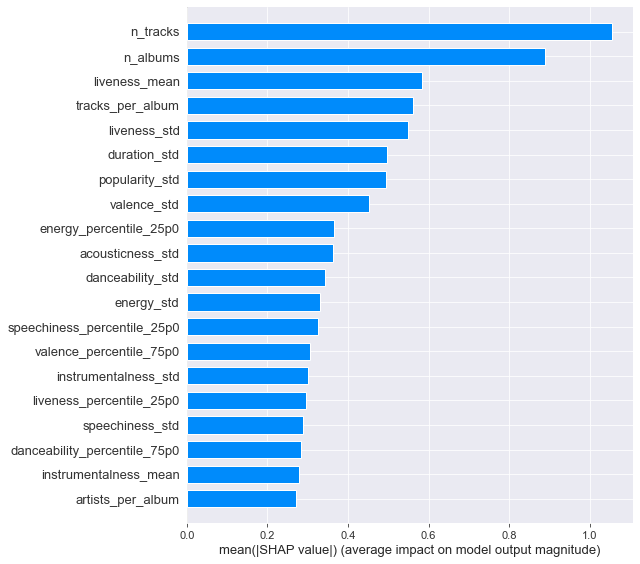

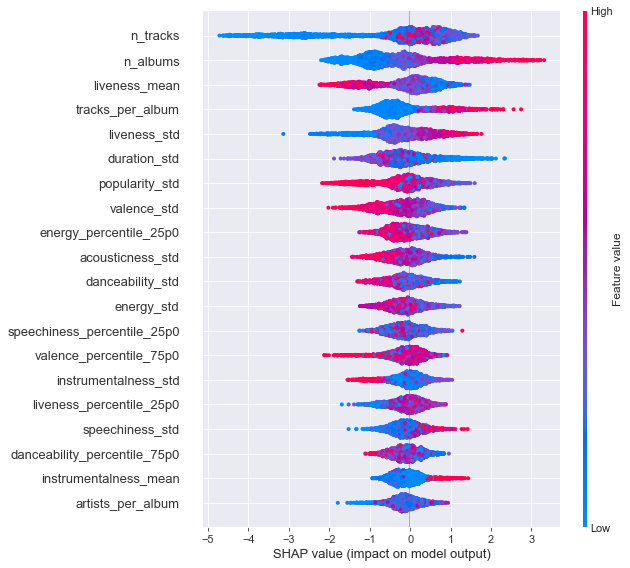

In [32]:
shap_helper("Country & Folk", dict_shap, dict_train)

## Dance & House

'Dance & House'

3031

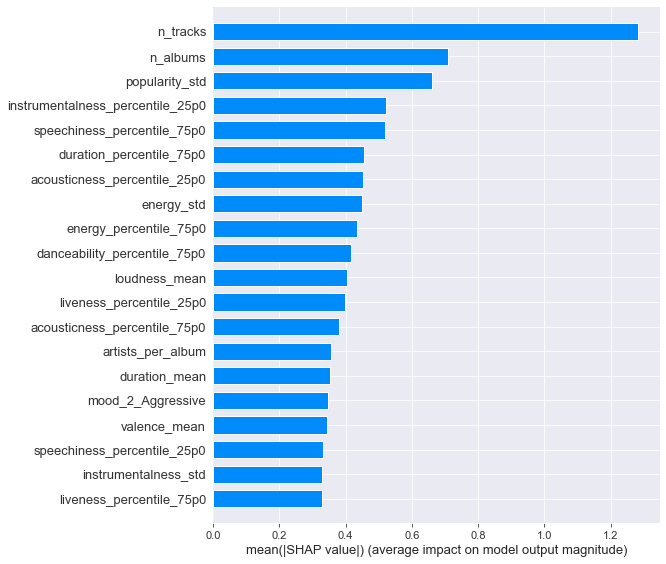

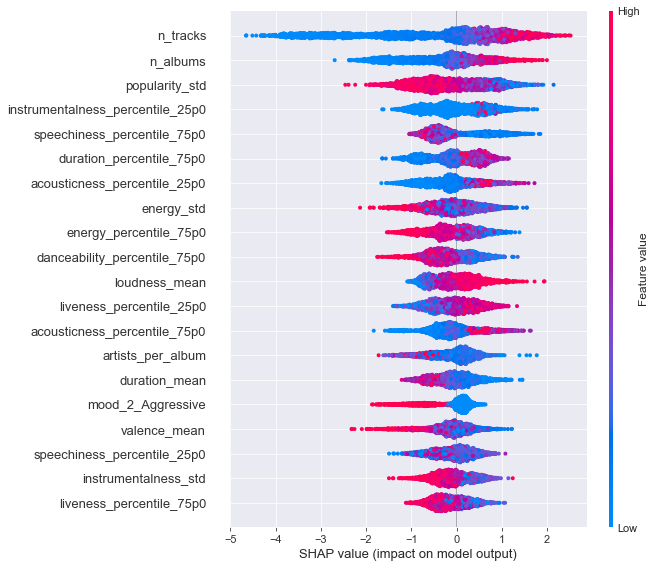

In [34]:
shap_helper("Dance & House", dict_shap, dict_train)

## Easy Listening

'Easy Listening'

262

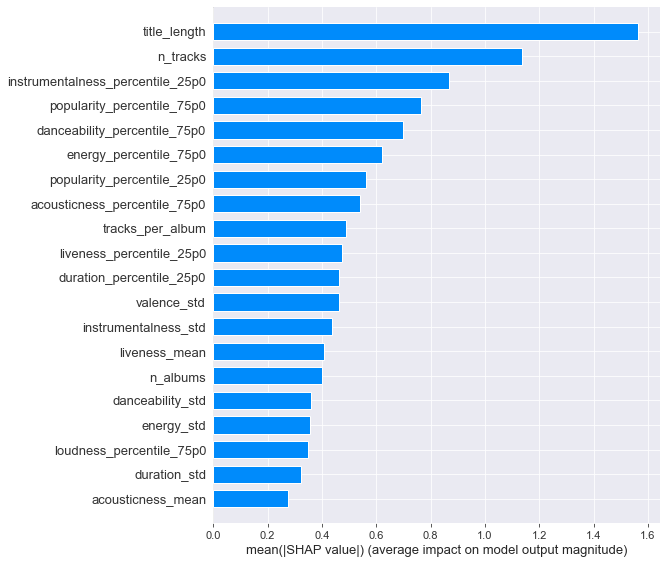

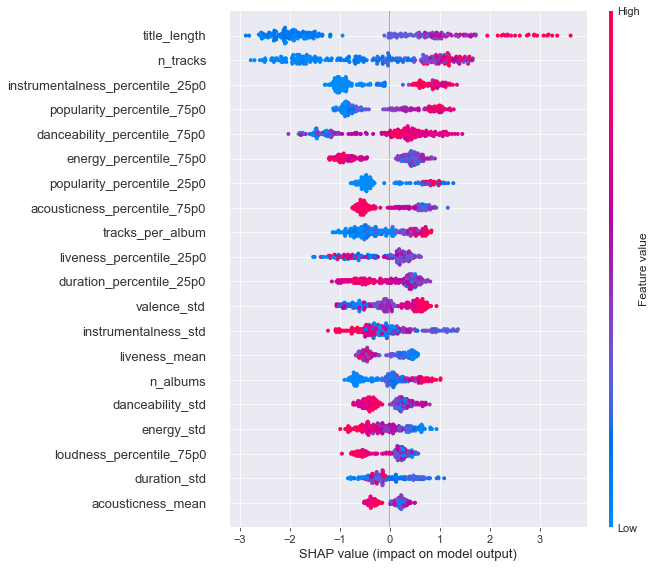

In [35]:
shap_helper("Easy Listening", dict_shap, dict_train)

## Electronica

'Electronica'

1635

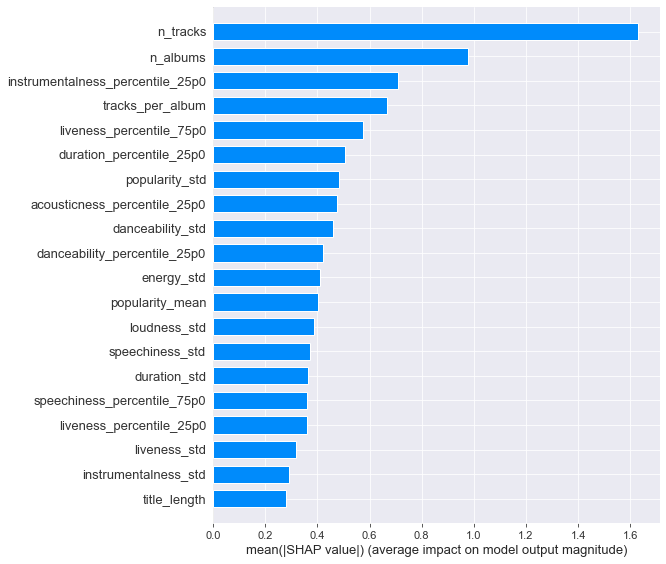

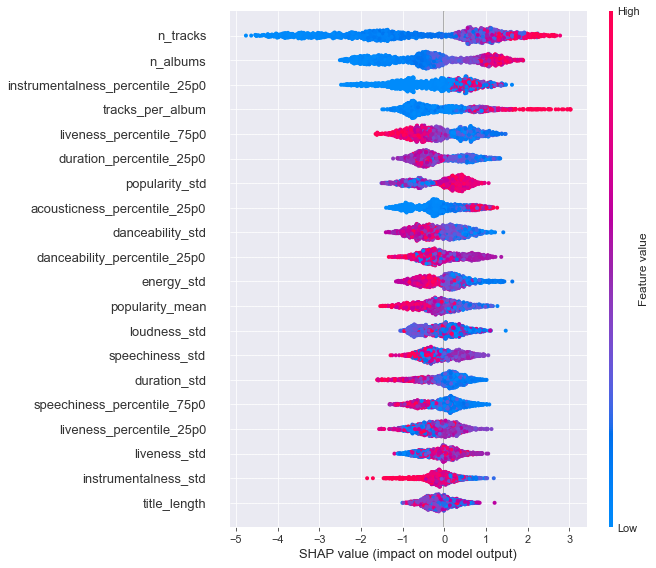

In [40]:
shap_helper("Electronica", dict_shap, dict_train)

## Indie Rock

'Indie Rock'

4800

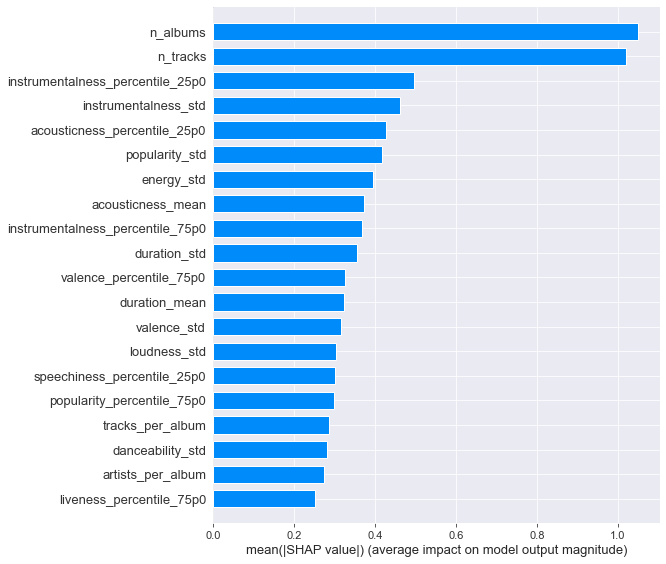

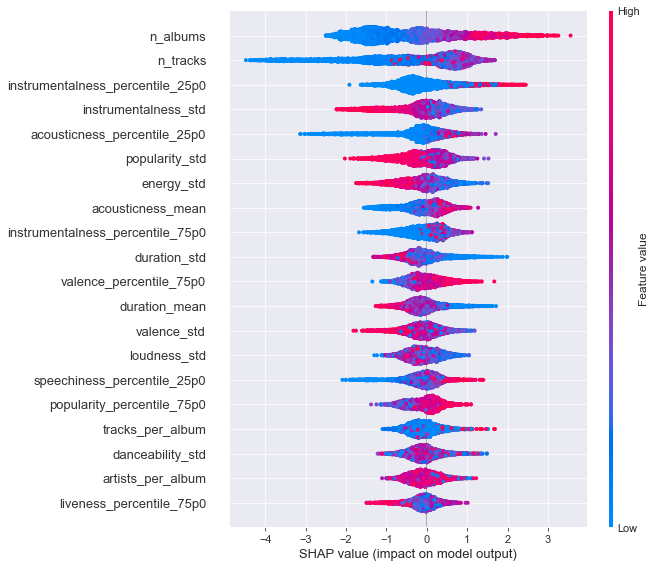

In [42]:
shap_helper("Indie Rock", dict_shap, dict_train)

## Jazz 

'Jazz'

721

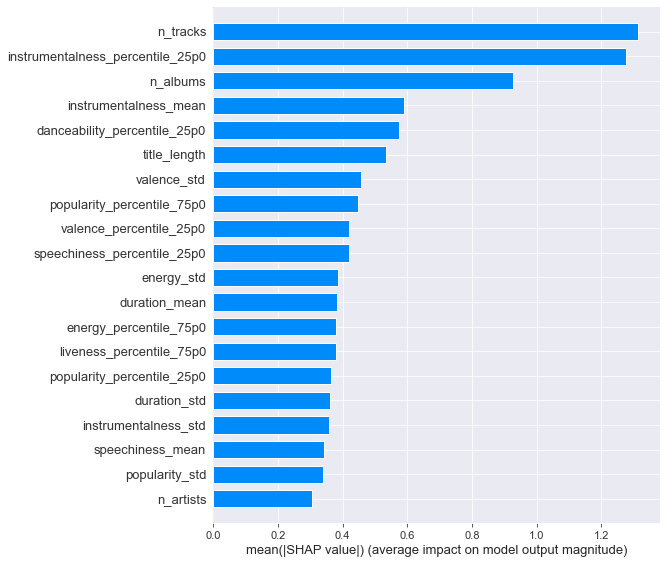

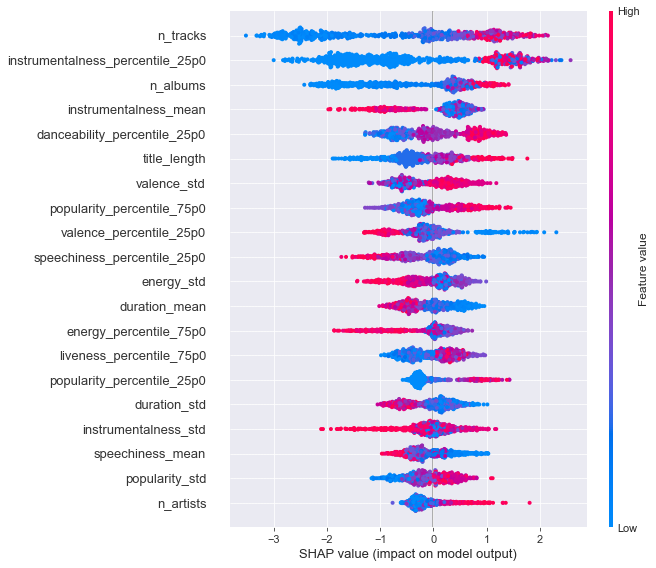

In [43]:
shap_helper("Jazz", dict_shap, dict_train)

## Latin

'Latin'

4979

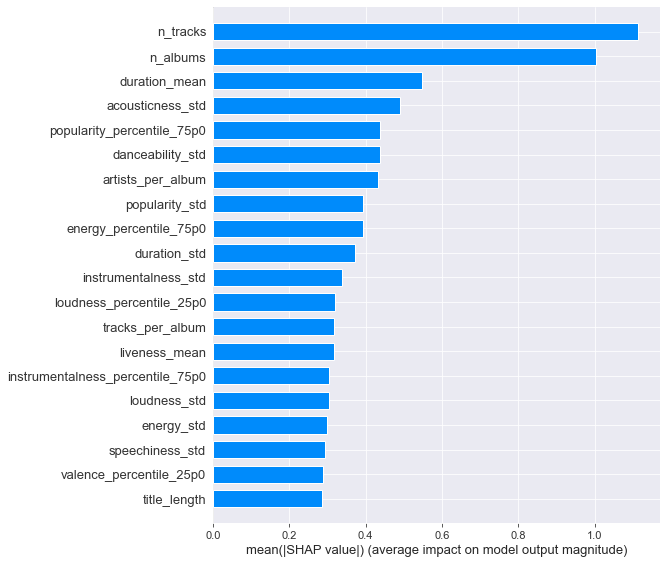

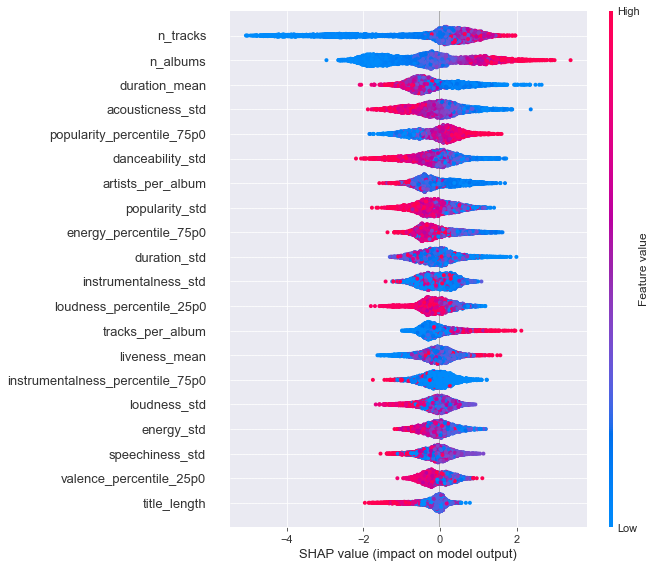

In [44]:
shap_helper("Latin", dict_shap, dict_train)

## Metal

'Metal'

1149

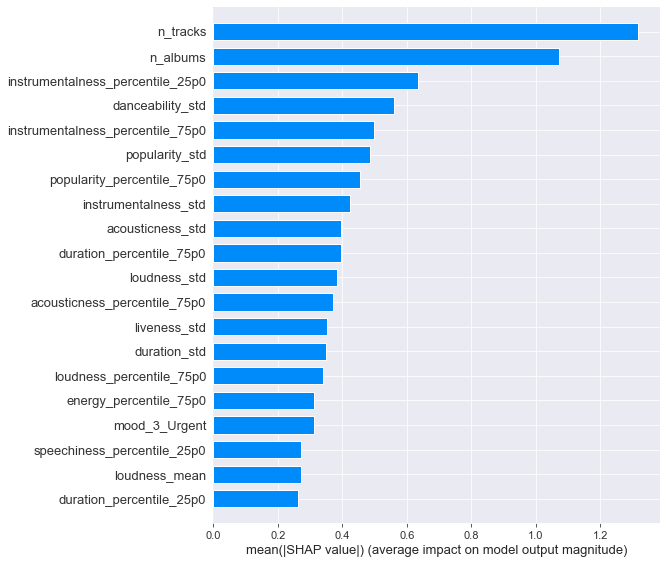

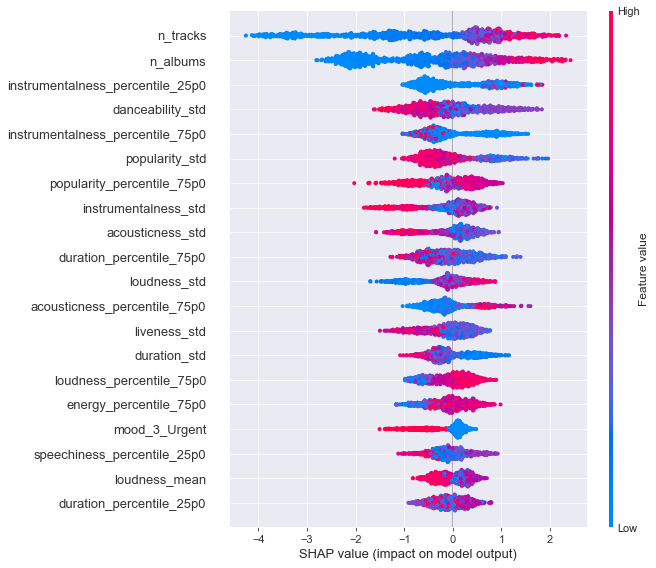

In [45]:
shap_helper("Metal", dict_shap, dict_train)

## Other

'Other'

39

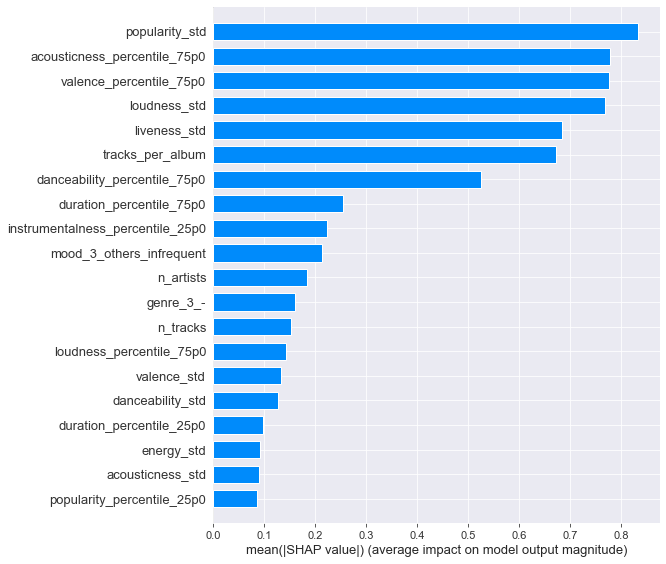

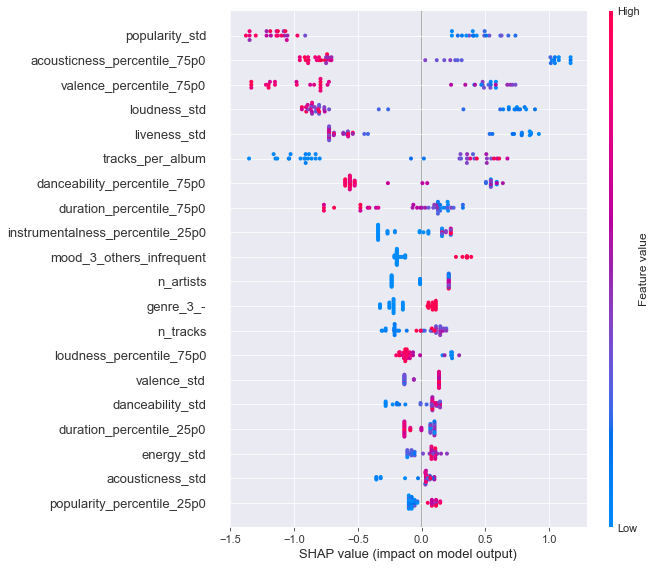

In [46]:
shap_helper("Other", dict_shap, dict_train)

##  New Age    

'New Age'

531

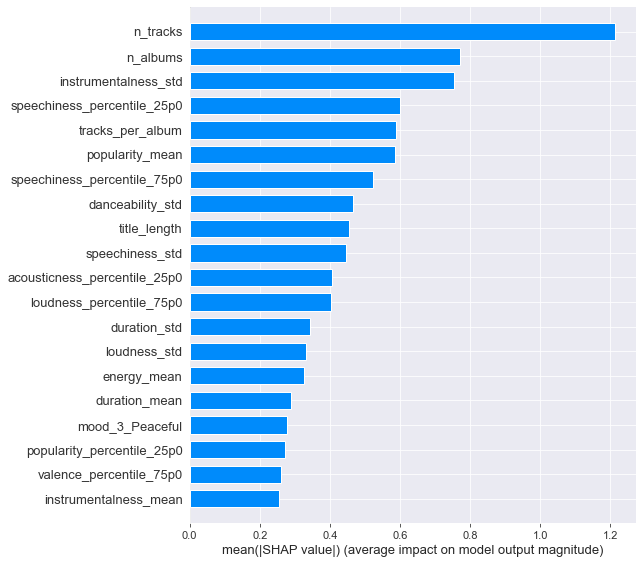

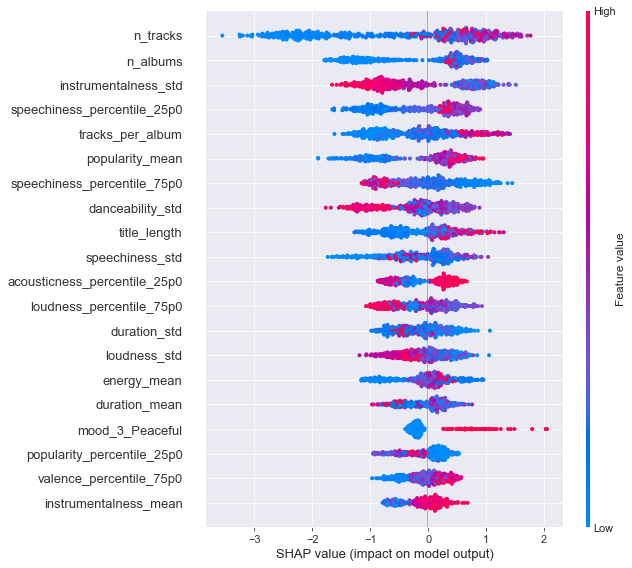

In [47]:
shap_helper("New Age", dict_shap, dict_train)

## Pop

'Pop'

9387

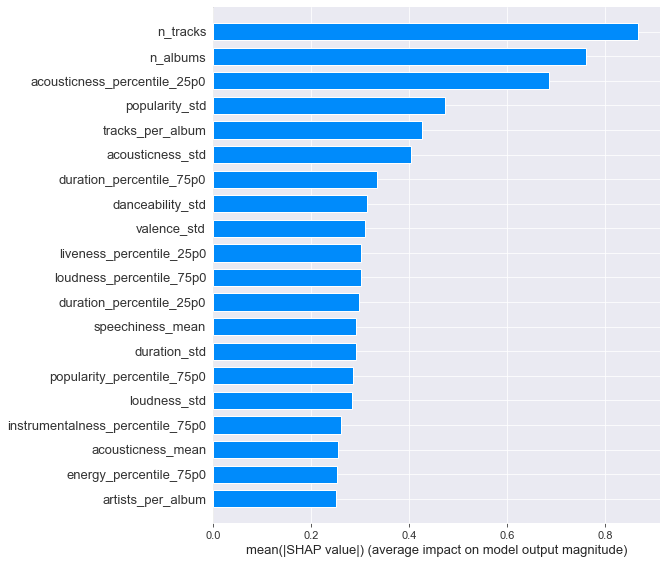

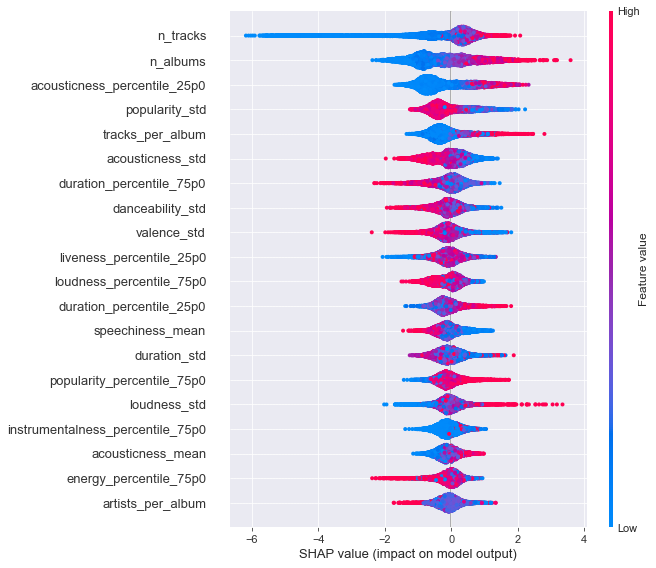

In [48]:
shap_helper("Pop", dict_shap, dict_train)

## Punk

'Punk'

1556

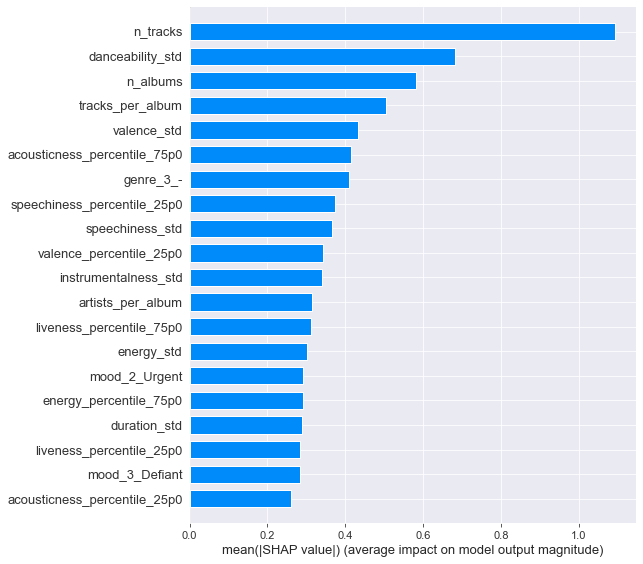

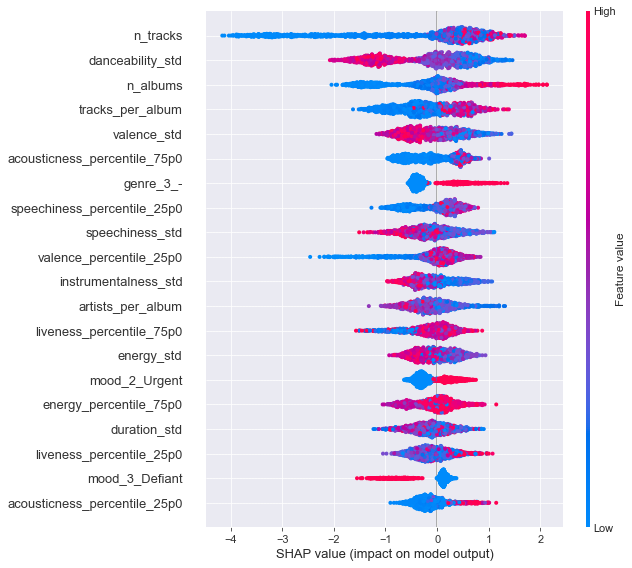

In [49]:
shap_helper("Punk", dict_shap, dict_train)

## R&B 

'R&B'

2965

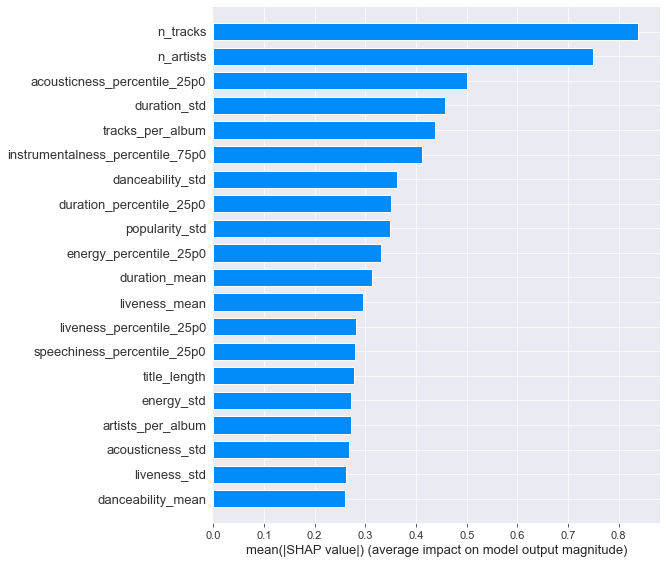

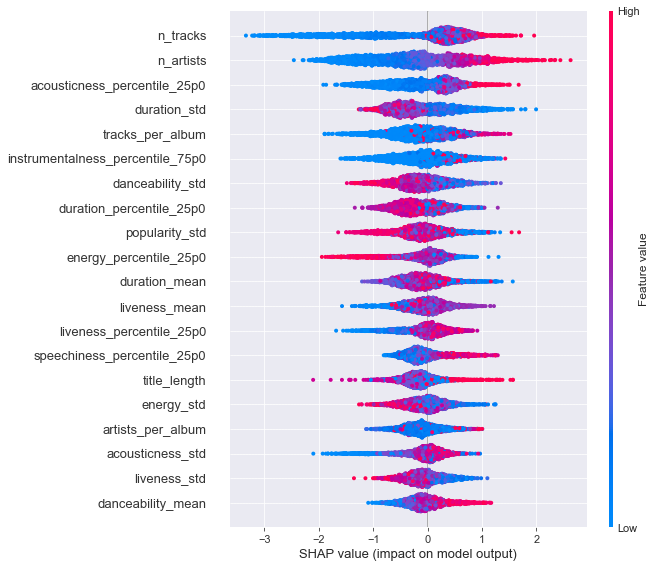

In [50]:
shap_helper("R&B", dict_shap, dict_train)

## Rap 

'Rap'

7259

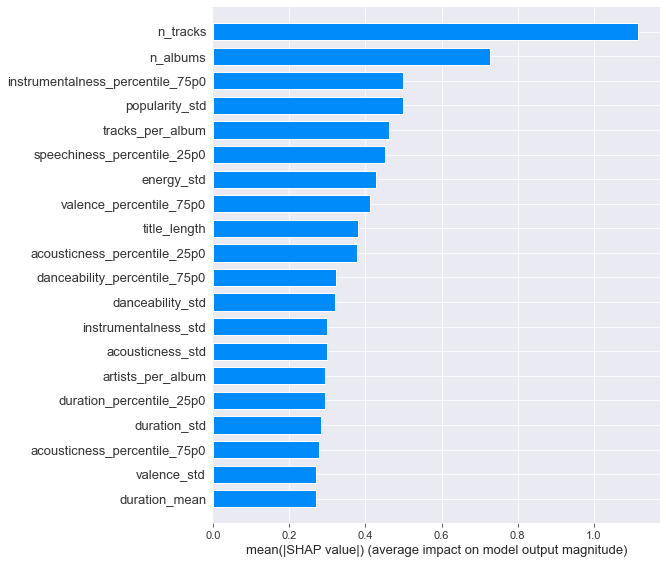

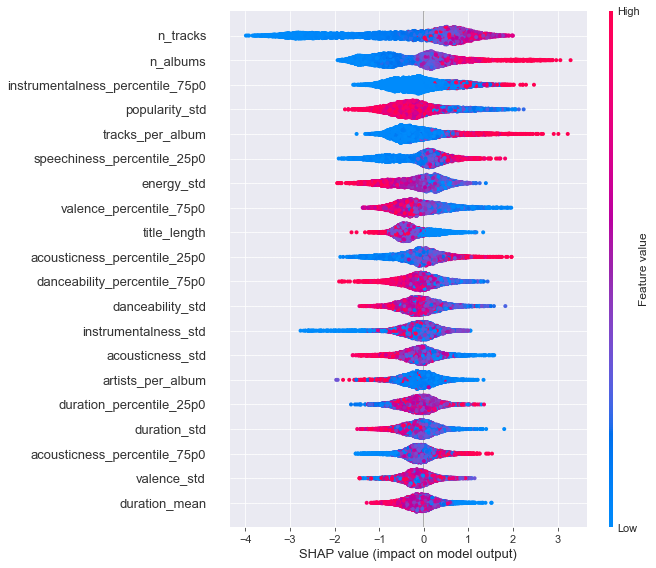

In [51]:
shap_helper("Rap", dict_shap, dict_train)

## Reggae 

'Reggae'

570

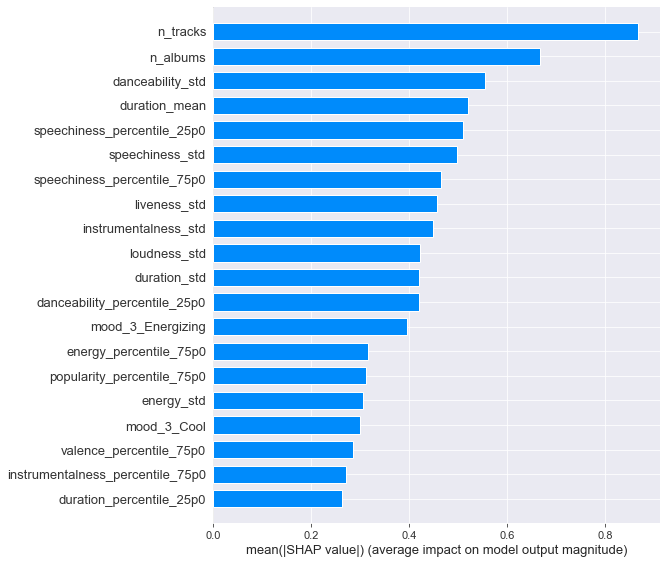

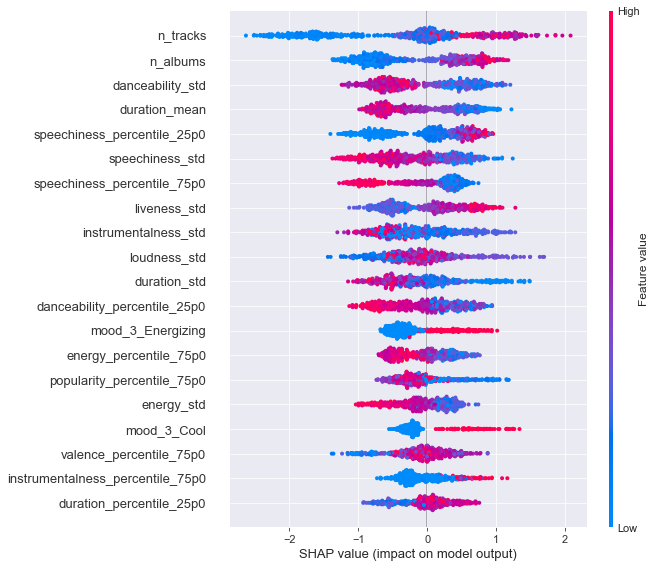

In [52]:
shap_helper("Reggae", dict_shap, dict_train)

## Religious 

'Religious'

1944

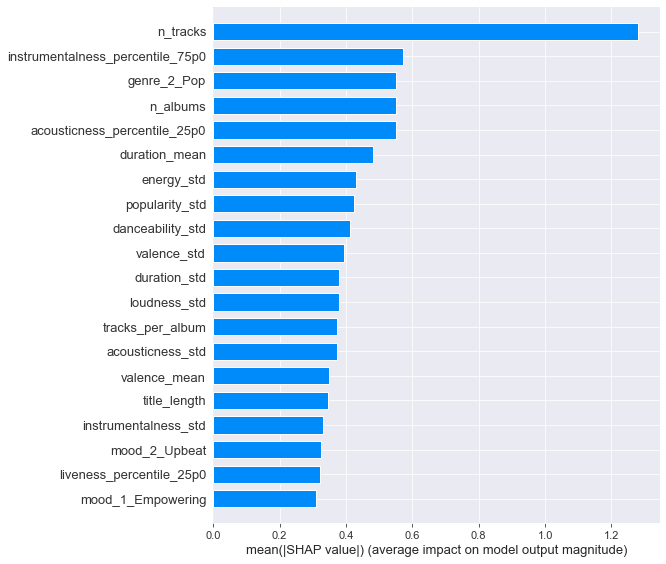

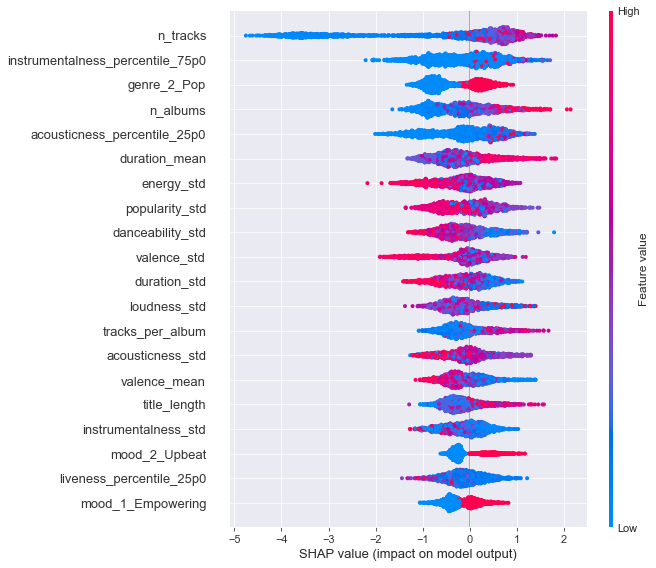

In [53]:
shap_helper("Religious", dict_shap, dict_train)

## Rock 

'Rock'

3799

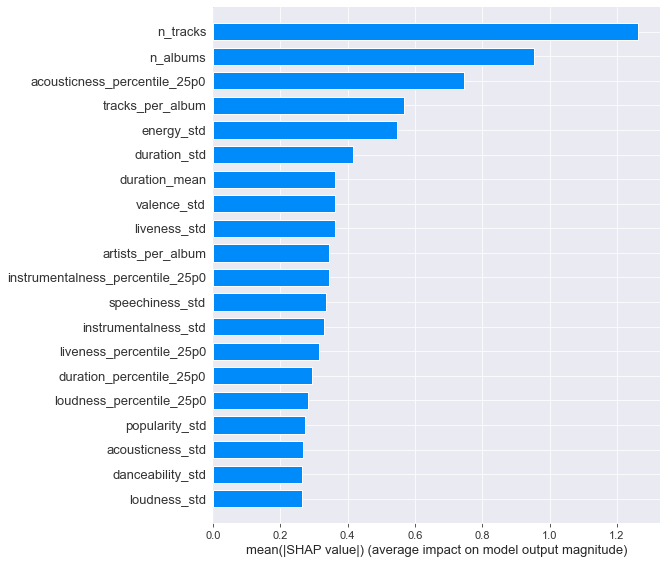

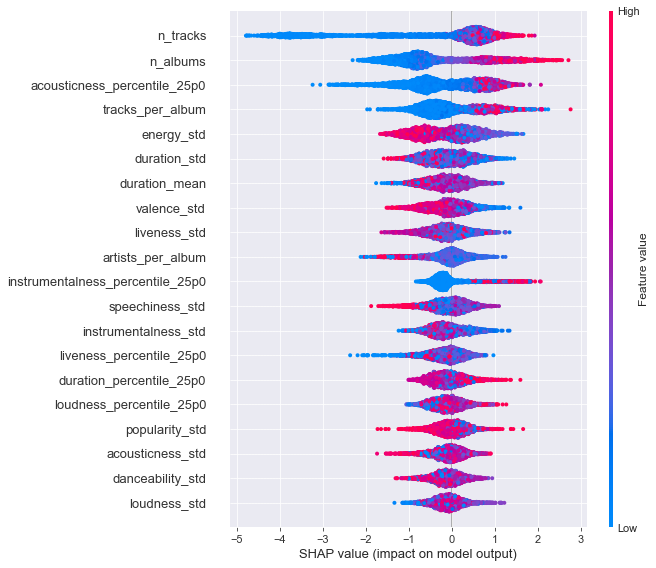

In [54]:
shap_helper("Rock", dict_shap, dict_train)

## Soundtrack 

'Soundtrack'

1923

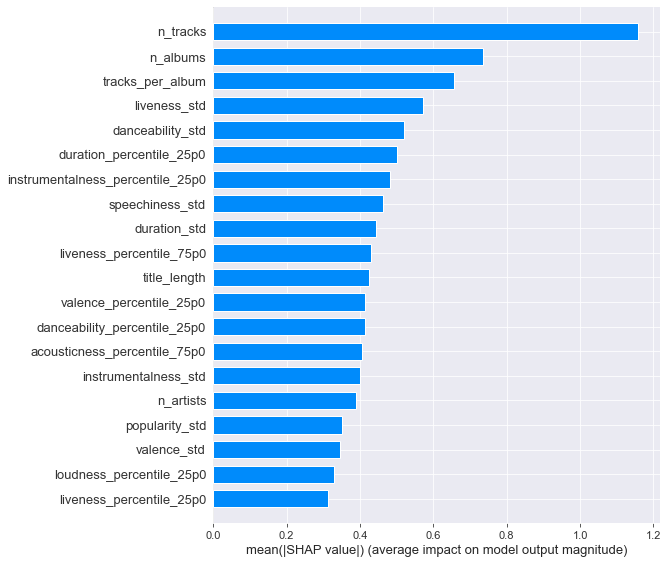

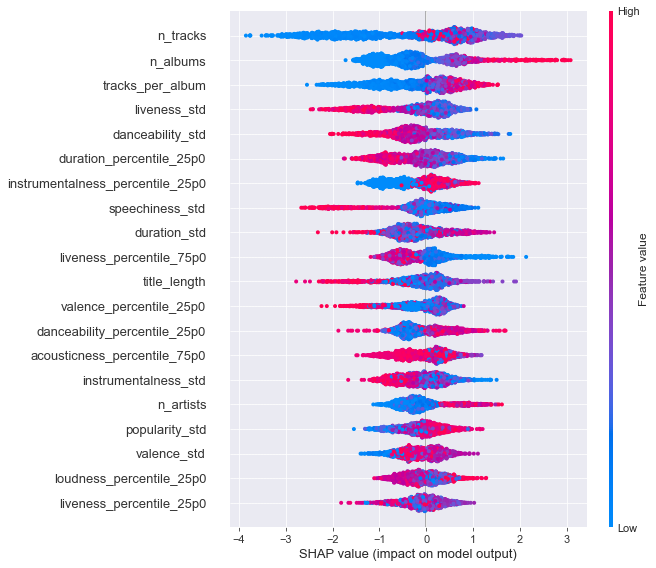

In [55]:
shap_helper("Soundtrack", dict_shap, dict_train)

In [56]:
## Spoken & Audio

'Spoken & Audio'

347

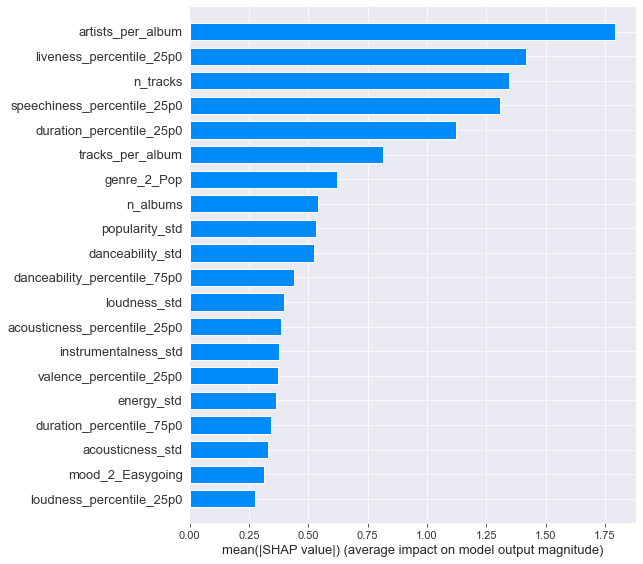

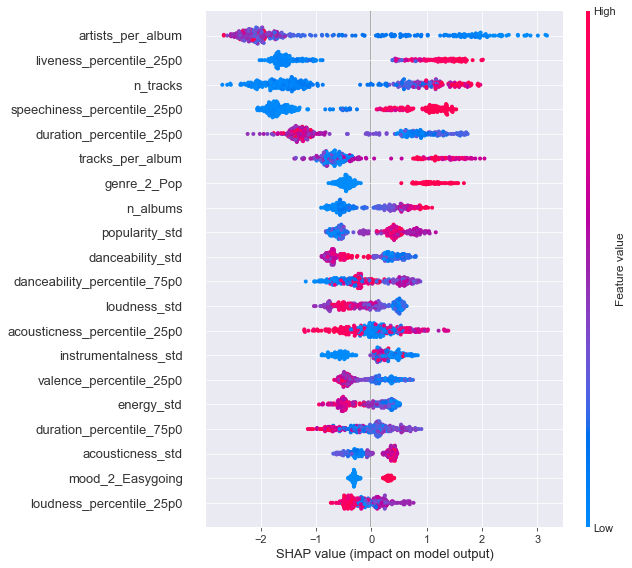

In [57]:
shap_helper("Spoken & Audio", dict_shap, dict_train)

In [58]:
## Traditional

'Traditional'

471

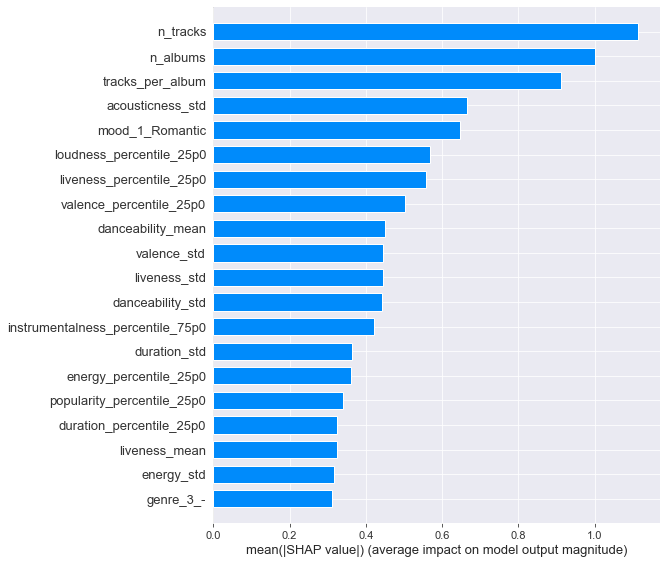

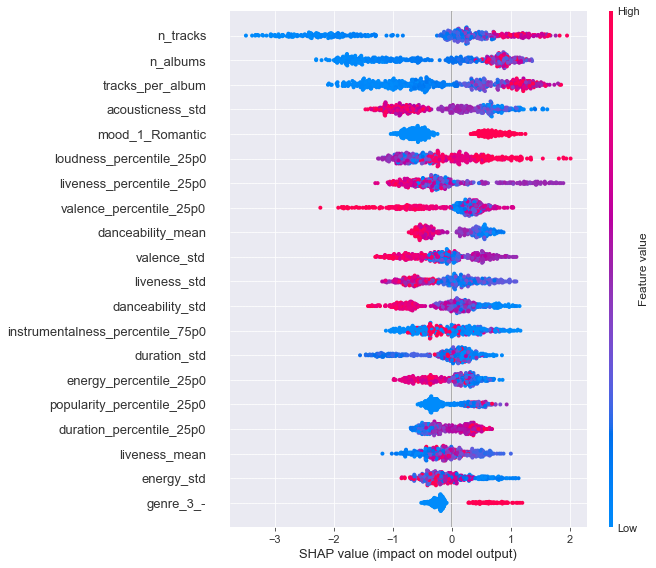

In [59]:
shap_helper("Traditional", dict_shap, dict_train)

In [60]:
## -

'-'

244

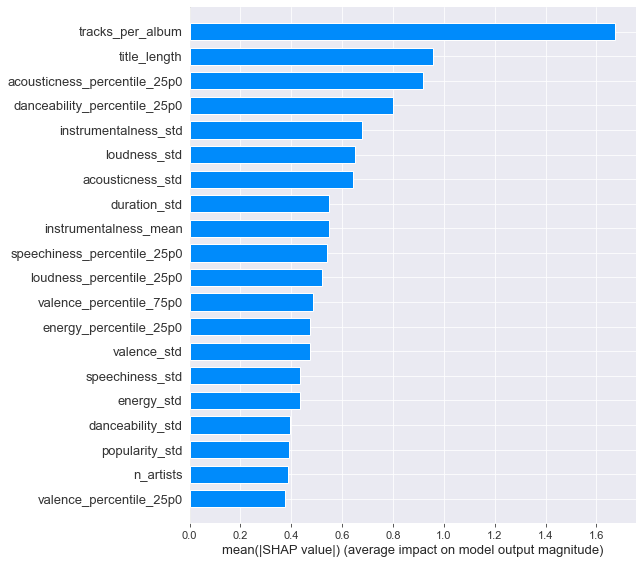

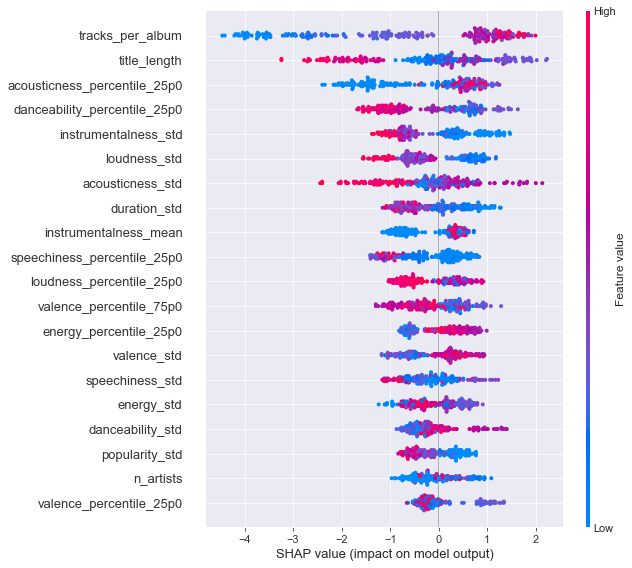

In [61]:
shap_helper("-", dict_shap, dict_train)